In [31]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy.cluster.hierarchy import DisjointSet
from collections import defaultdict
import copy

In [2]:
class Network(object):
    def __init__(self, num_nodes):
        self.adj = {i: set() for i in range(num_nodes)}
        self.num_nodes = num_nodes

    def add_edge(self, i, j):
        self.adj[i].add(j)
        self.adj[j].add(i)

    def neighbors(self, i):
        return self.adj[i]

    def edge_list(self):
        return [(i, j) for i in self.adj for j in self.adj[i] if i < j]

class Poisson_Network(Network):
    def __init__(self, num_nodes, k_avg):
        super().__init__(num_nodes)

        S = np.array([i for i in range(num_nodes) for _ in range(np.random.poisson(k_avg))])
        S = np.random.permutation(S)
        if len(S) % 2:
            S = S[:-1]
        S = S.reshape(-1, 2)

        for k in range(len(S)):
            i, j = S[k][0], S[k][1]
            if i != j:
                self.add_edge(i, j)


class Geometric_Network(Network):
    def __init__(self, num_nodes, k_avg):
        super().__init__(num_nodes)

        S = np.array([i for i in range(num_nodes) for _ in range(np.random.geometric(1 / (k_avg + 1))-1)])
        S = np.random.permutation(S)
        if len(S) % 2:
            S = S[:-1]
        S = S.reshape(-1, 2)

        for k in range(len(S)):
            i, j = S[k][0], S[k][1]
            if i != j:
                self.add_edge(i, j)

In [3]:
class Infectious_Network():
    def __init__(self, network: Network, infection_probi: float, initial_infection: float):
        self.network = network
        self.infection_probi = infection_probi
        self.num_nodes = len(self.network.adj.keys())

        self.infectious = set()
        self.recovered = set()

        for _ in range(math.floor(initial_infection*self.num_nodes)):
            infect_node = np.random.randint(0, self.num_nodes)
            while infect_node in self.infectious:
                infect_node = np.random.randint(0, self.num_nodes)
            self.infectious.add(infect_node)

    def increment_time(self):
        new_infectious = set()
        for infect_node in self.infectious:
            for neighbour in self.network.neighbors(infect_node):
                if neighbour not in self.recovered and neighbour not in self.infectious and np.random.binomial(1, self.infection_probi):   
                    new_infectious.add(neighbour)
            self.recovered.add(infect_node)
        self.infectious = new_infectious


    def increment_till_extinction(self):
        S, I, R = [self.num_nodes-len(self.infectious)], [len(self.infectious)], [0]
        while len(self.infectious):
            self.increment_time()
            S.append(self.num_nodes-len(self.infectious)-len(self.recovered))
            I.append(len(self.infectious))
            R.append(len(self.recovered))

        return S, I, R

    def iterative_outbreak_size(self, tol):
        s_array_new = np.random.rand(self.num_nodes)
        s_array = np.zeros(len(s_array_new))

        iter = 0
        while np.max(np.abs(s_array - s_array_new)) > tol and iter < 30:
            s_array = s_array_new.copy()
            s_array_new = np.ones(len(s_array))
            for i in range(len(s_array)):
                s_i = s_array[i]
                for j in self.network.neighbors(i):
                    s_array_new[i] *= (1 - self.infection_probi + s_array[j] * self.infection_probi)
            iter += 1
        
        return self.num_nodes - np.sum(s_array_new > 0.5)

    def disjoint_set_outbreak_size(self):
        disjoint = DisjointSet(range(self.num_nodes))

        for i, j in self.network.edge_list():
            if np.random.binomial(1, self.infection_probi):
                disjoint.merge(i, j)
        num_nodes_infected = [disjoint.subset_size(node) for node in range(self.num_nodes)]
        mean = np.mean(num_nodes_infected)
        std = np.std(num_nodes_infected)

        return mean, std/mean 


In [4]:
n = 10000
k = 20
poisson_network = Poisson_Network(n, k)
geometric_network = Geometric_Network(n, k)
poisson_infection_probi = 0.06
geometric_infection_probi = 0.03

Q1

In [5]:
def find_x_vector(network: Network, infection_probi, sample_size):
    x_vector = np.zeros(network.num_nodes)
    for _ in range(sample_size):
        infectious_network = Infectious_Network(network, infection_probi, 0.01)
        infectious_network.increment_till_extinction()
        for i in infectious_network.recovered:
            x_vector[i] += 1    
    return x_vector / sample_size

In [6]:
sample_size = 1000
x_vector = find_x_vector(poisson_network, poisson_infection_probi, sample_size) 

In [7]:
x_vector_geometric = find_x_vector(geometric_network, geometric_infection_probi, sample_size) 

In [8]:
print(x_vector)

[0.427 0.401 0.346 ... 0.303 0.382 0.283]


Q2

In [9]:
k_array = [5, 10, 15, 20]

In [10]:
# poisson network
x_vector_array_poisson = []
k_vector_array_poisson = []

for k in k_array:
    poisson_network_k = Poisson_Network(n, k)
    x_vector = find_x_vector(poisson_network_k, poisson_infection_probi, sample_size)
    k_vector = [len(neighbours) for neighbours in poisson_network_k.adj.values()]
    x_vector_array_poisson.append(x_vector)
    k_vector_array_poisson.append(k_vector)

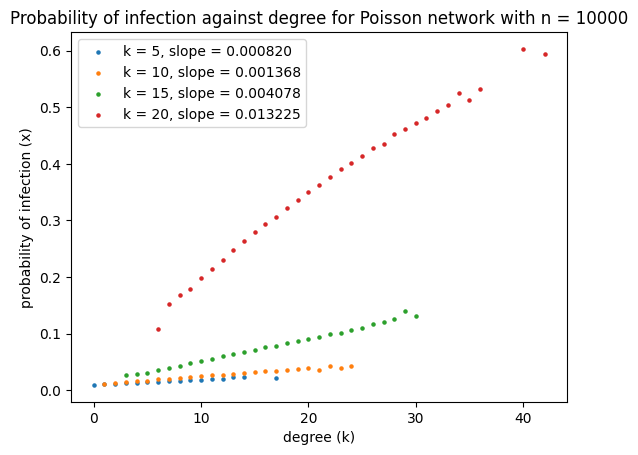

In [11]:
for idx in range(len(k_array)):
    k, x_vector, k_vector = k_array[idx], x_vector_array_poisson[idx], k_vector_array_poisson[idx]
    x_against_k_list = defaultdict(list)
    for i in range(len(x_vector)):
        x_against_k_list[k_vector[i]].append(x_vector[i])
        
    x_val_array, k_val_array = [], []

    for k_val, x_list in x_against_k_list.items():
        if len(x_list) > 0:
            k_val_array.append(k_val)
            x_val_array.append(np.mean(x_list))
    
    slope, intercept = np.polyfit(k_val_array, x_val_array, 1)
    
    plt.scatter(k_val_array, x_val_array, label="k = {k}, slope = {slope:.6f}".format(k=k, slope=slope), s=5)
    plt.xlabel("degree (k)")
    plt.ylabel("probability of infection (x)")
    plt.legend()

plt.title(f"Probability of infection against degree for Poisson network with n = {n}")
plt.show()

In [12]:
# geometric network
x_vector_array_geometric = []
k_vector_array_geometric = []

for k in k_array:
    geometric_network_k = Geometric_Network(n, k)
    x_vector = find_x_vector(geometric_network_k, geometric_infection_probi, sample_size)
    k_vector = [len(neighbours) for neighbours in geometric_network_k.adj.values()]
    x_vector_array_geometric.append(x_vector)
    k_vector_array_geometric.append(k_vector)

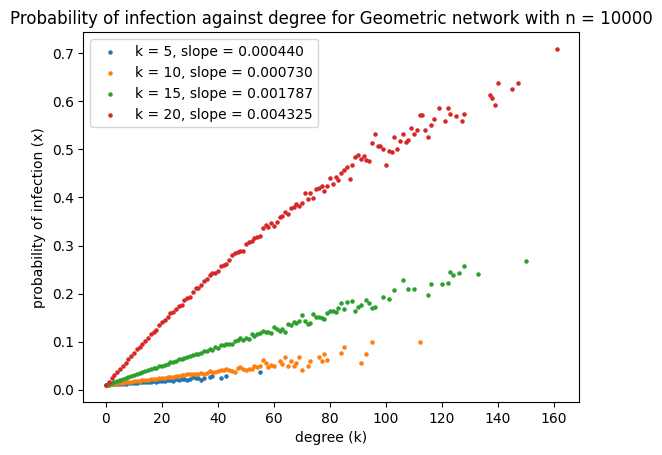

In [13]:
for idx in range(len(k_array)):
    k, x_vector, k_vector = k_array[idx], x_vector_array_geometric[idx], k_vector_array_geometric[idx]
    x_against_k_list = defaultdict(list)
    for i in range(len(x_vector)):
        x_against_k_list[k_vector[i]].append(x_vector[i])
        
    x_val_array, k_val_array = [], []

    for k_val, x_list in x_against_k_list.items():
        if len(x_list) > 0:
            k_val_array.append(k_val)
            x_val_array.append(np.mean(x_list))
    
    slope, intercept = np.polyfit(k_val_array, x_val_array, 1)
    
    plt.scatter(k_val_array, x_val_array, label="k = {k}, slope = {slope:.6f}".format(k=k, slope=slope), s=5)
    plt.xlabel("degree (k)")
    plt.ylabel("probability of infection (x)")
    plt.legend()

plt.title(f"Probability of infection against degree for Geometric network with n = {n}")
plt.show()

Q3

In [14]:
def disease_paradox(network: Network, x_vector):
    node_infection_probi = []
    neighbour_node_infection_probi = []

    for _ in range(sample_size):
        i = np.random.randint(0, n)
        while not len(network.neighbors(i)):
            i = np.random.randint(0, n)
        j = random.choices(list(network.neighbors(i)), k=1)[0]
        node_infection_probi.append(x_vector[i])
        neighbour_node_infection_probi.append(x_vector[j])

    return node_infection_probi, neighbour_node_infection_probi

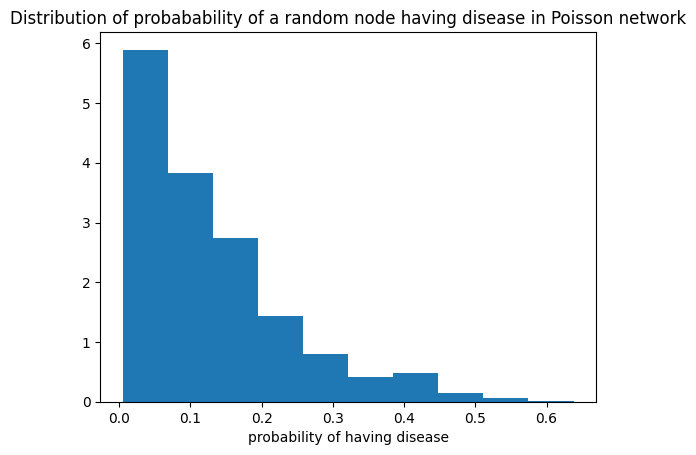

Average of node: 0.12781399999999998


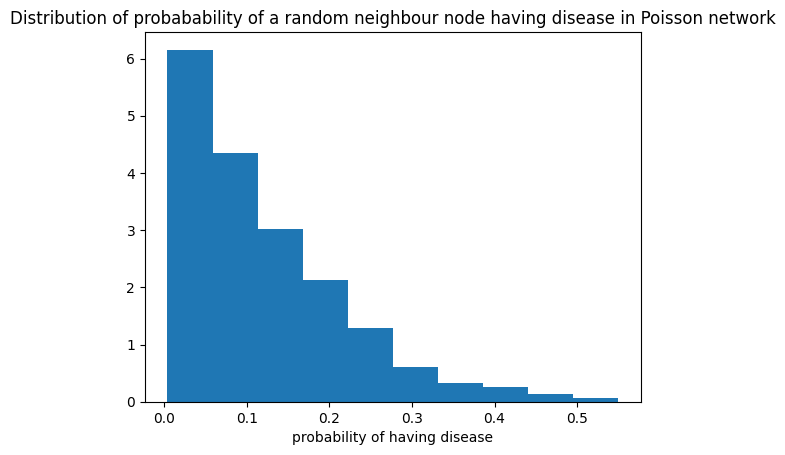

Average of neighbour node: 0.119661


In [15]:
# Poisson
node_infection_probi_poisson, neighbour_node_infection_probi_poisson = disease_paradox(poisson_network, x_vector)

plt.hist(node_infection_probi_poisson, density=True)
plt.title("Distribution of probabability of a random node having disease in Poisson network")
plt.xlabel("probability of having disease")
plt.show()
print(f"Average of node: {np.average(node_infection_probi_poisson)}")

plt.hist(neighbour_node_infection_probi_poisson, density=True)
plt.title("Distribution of probabability of a random neighbour node having disease in Poisson network")
plt.xlabel("probability of having disease")
plt.show()
print(f"Average of neighbour node: {np.average(neighbour_node_infection_probi_poisson)}")

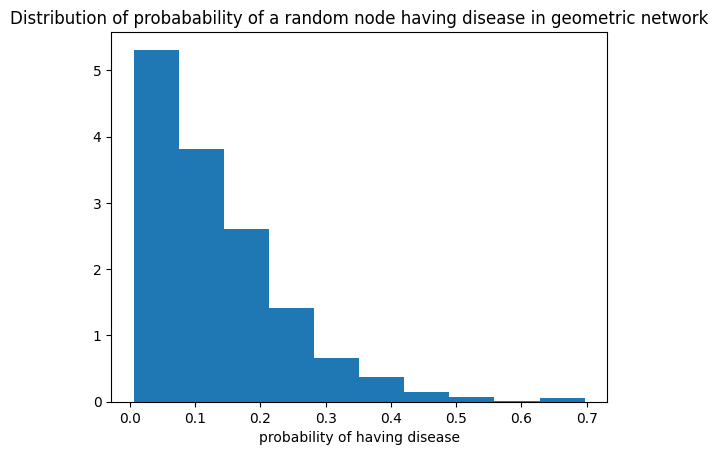

Average of node: 0.13472199999999998


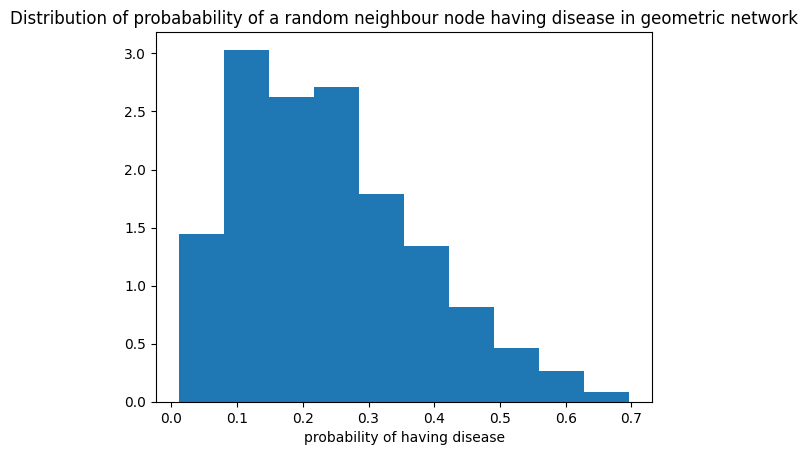

Average of neighbour node: 0.24013900000000002


In [16]:
# Geometric
node_infection_probi_geometric, neighbour_node_infection_probi_geometric = disease_paradox(geometric_network, x_vector_geometric)

plt.hist(node_infection_probi_geometric, density=True)
plt.title("Distribution of probabability of a random node having disease in geometric network")
plt.xlabel("probability of having disease")
plt.show()
print(f"Average of node: {np.average(node_infection_probi_geometric)}")

plt.hist(neighbour_node_infection_probi_geometric, density=True)
plt.title("Distribution of probabability of a random neighbour node having disease in geometric network")
plt.xlabel("probability of having disease")
plt.show()
print(f"Average of neighbour node: {np.average(neighbour_node_infection_probi_geometric)}")

Q4

In [59]:
class Network_with_Removable_Node(Network):
    def remove_node(self, i):
        for j in self.neighbors(i):
            self.adj[j].remove(i)
        del self.adj[i]

    def existing_nodes(self):
        return list(self.adj.keys())
    
class Poisson_Network_with_Removable_Node(Poisson_Network, Network_with_Removable_Node):
    def __init__(self, num_nodes, k_avg):
        Poisson_Network.__init__(self, num_nodes, k_avg)

class Geometric_Network_with_Removable_Node(Geometric_Network, Network_with_Removable_Node):
    def __init__(self, num_nodes, k_avg):
        Geometric_Network.__init__(self, num_nodes, k_avg)

class Infectious_Network_with_Removable_Node(Infectious_Network):
    def __init__(self, network: Network_with_Removable_Node, infection_probi: float, initial_infection: float, num_nodes: int):
        self.network = network
        self.infection_probi = infection_probi
        self.num_nodes = num_nodes

        self.infectious = set()
        self.recovered = set()

        for _ in range(math.floor(initial_infection*self.num_nodes)):
            infect_node = random.choice(network.existing_nodes())
            while infect_node in self.infectious:
                infect_node = random.choice(network.existing_nodes())
            self.infectious.add(infect_node)

In [53]:
vaccination_rate_array = [0, 0.2, 0.4]
infection_probi_array = np.linspace(0, 1, 50)

def vaccination_simulation(removable_network: Network_with_Removable_Node, initial_infection: float):
    outbreak_array = [[], [], []]

    num_nodes = removable_network.num_nodes

    for num, vaccination_rate in enumerate(vaccination_rate_array):
        print(vaccination_rate)
        for infection_probi in infection_probi_array:
            removable_network_copy = copy.deepcopy(removable_network)
            vaccinated_nodes = random.sample(list(range(num_nodes)), math.floor(vaccination_rate*num_nodes))
            for i in vaccinated_nodes:
                removable_network_copy.remove_node(i)
            infectious_removable_network = Infectious_Network_with_Removable_Node(removable_network_copy, infection_probi, initial_infection, num_nodes)
            S, I, R = infectious_removable_network.increment_till_extinction()
            outbreak_array[num].append(R[-1])

    return outbreak_array

In [54]:
# Poisson
poisson_removable_network = Poisson_Network_with_Removable_Node(n, k)
poisson_outbreak_array = vaccination_simulation(poisson_removable_network, 0.01)

0
0.2
0.4


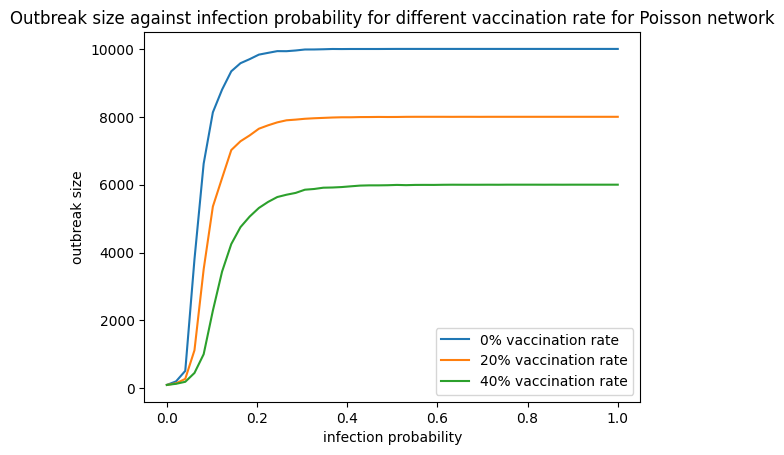

In [55]:
plt.plot(infection_probi_array, poisson_outbreak_array[0], label="0% vaccination rate")
plt.plot(infection_probi_array, poisson_outbreak_array[1], label="20% vaccination rate")
plt.plot(infection_probi_array, poisson_outbreak_array[2], label="40% vaccination rate")
plt.legend()
plt.title("Outbreak size against infection probability for different vaccination rate for Poisson network")
plt.xlabel("infection probability")
plt.ylabel("outbreak size")
plt.show()

In [60]:
# Geometric
geometric_removable_network = Geometric_Network_with_Removable_Node(n, k)
geometric_outbreak_array = vaccination_simulation(geometric_removable_network, 0.01)

0
0.2
0.4


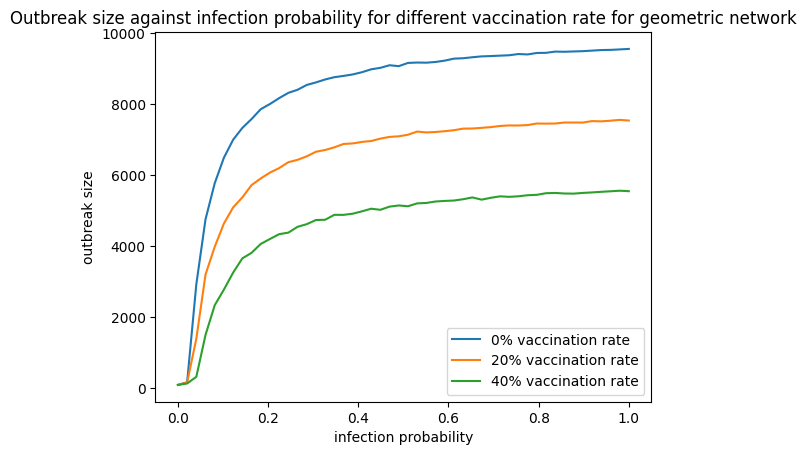

In [61]:
plt.plot(infection_probi_array, geometric_outbreak_array[0], label="0% vaccination rate")
plt.plot(infection_probi_array, geometric_outbreak_array[1], label="20% vaccination rate")
plt.plot(infection_probi_array, geometric_outbreak_array[2], label="40% vaccination rate")
plt.legend()
plt.title("Outbreak size against infection probability for different vaccination rate for geometric network")
plt.xlabel("infection probability")
plt.ylabel("outbreak size")
plt.show()

In [78]:
def vaccination_simulation_with_paradox(removable_network: Network_with_Removable_Node, vaccination_rate: float, initial_infection: float):
    outbreak_array_no_paradox = []
    outbreak_array_paradox = []

    num_nodes = removable_network.num_nodes
    
    for infection_probi in infection_probi_array:
        removable_network_copy = copy.deepcopy(removable_network)
        vaccinated_nodes = set()
        for _ in range(math.floor(vaccination_rate*num_nodes)):
            i = np.random.randint(0, n)
            while ( not removable_network_copy.adj.get(i) 
                   or not len(removable_network_copy.neighbors(i)) 
                   or not removable_network_copy.neighbors(i)^vaccinated_nodes ):
                i = np.random.randint(0, n)
            j = random.choices(list(removable_network_copy.neighbors(i)), k=1)[0] 
            while j in vaccinated_nodes:
                j = random.choices(list(removable_network_copy.neighbors(i)), k=1)[0] 
            removable_network_copy.remove_node(i)
        infectious_removable_network = Infectious_Network_with_Removable_Node(removable_network_copy, infection_probi, initial_infection, num_nodes)
        S, I, R = infectious_removable_network.increment_till_extinction()
        outbreak_array_paradox.append(R[-1])

    for infection_probi in infection_probi_array:
        removable_network_copy = copy.deepcopy(removable_network)
        vaccinated_nodes = random.sample(list(range(num_nodes)), math.floor(vaccination_rate*num_nodes))
        for i in vaccinated_nodes:
            removable_network_copy.remove_node(i)
        infectious_removable_network = Infectious_Network_with_Removable_Node(removable_network_copy, infection_probi, initial_infection, num_nodes)
        S, I, R = infectious_removable_network.increment_till_extinction()
        outbreak_array_no_paradox.append(R[-1])

    return outbreak_array_no_paradox, outbreak_array_paradox

In [79]:
# Poisson
poisson_removable_network = Poisson_Network_with_Removable_Node(n, k)
poisson_outbreak_array_no_paradox, poisson_outbreak_array_paradox = vaccination_simulation_with_paradox(poisson_removable_network, 0.4, 0.01)

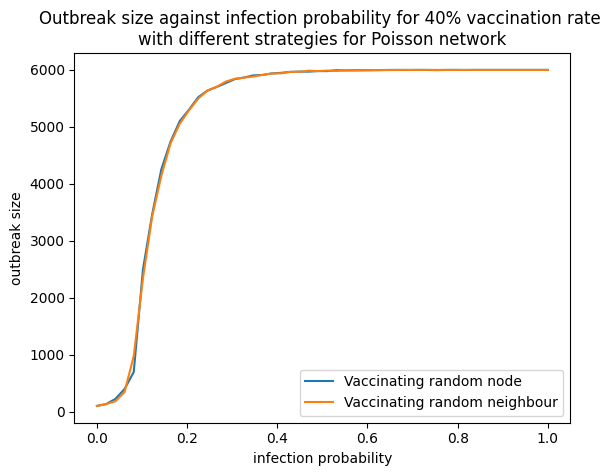

In [84]:
plt.plot(infection_probi_array, poisson_outbreak_array_no_paradox, label="Vaccinating random node")
plt.plot(infection_probi_array, poisson_outbreak_array_paradox, label="Vaccinating random neighbour")
plt.legend()
plt.title("Outbreak size against infection probability for 40% vaccination rate \nwith different strategies for Poisson network")
plt.xlabel("infection probability")
plt.ylabel("outbreak size")
plt.show()

In [81]:
# Geometric
geometric_removable_network = Geometric_Network_with_Removable_Node(n, k)
geometric_outbreak_array_no_paradox, geometric_outbreak_array_paradox = vaccination_simulation_with_paradox(geometric_removable_network, 0.4, 0.01)

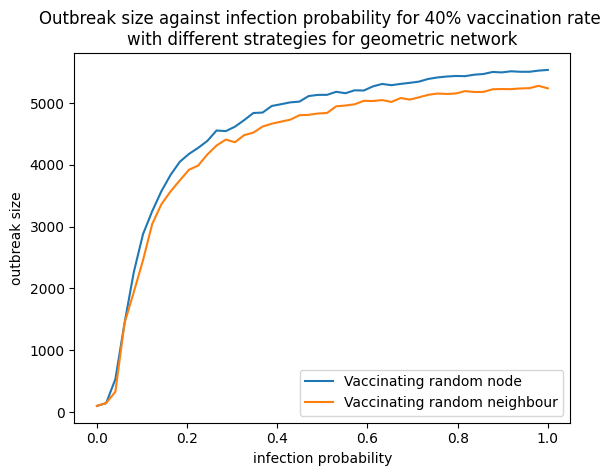

In [83]:
plt.plot(infection_probi_array, geometric_outbreak_array_no_paradox, label="Vaccinating random node")
plt.plot(infection_probi_array, geometric_outbreak_array_paradox, label="Vaccinating random neighbour")
plt.legend()
plt.title("Outbreak size against infection probability for 40% vaccination rate \nwith different strategies for geometric network")
plt.xlabel("infection probability")
plt.ylabel("outbreak size")
plt.show()

Q5

In [97]:
def iterative_outbreak_size_no_paradox(network: Network, infection_probi, tol, vaccination_rate):
    s_array_new = np.random.rand(network.num_nodes)
    s_array = np.zeros(len(s_array_new))

    iter = 0
    while np.max(np.abs(s_array - s_array_new)) > tol and iter < 20:
        s_array = s_array_new.copy()
        s_array_new = np.ones(len(s_array))
        for i in range(len(s_array)):
            s_i = s_array[i]
            for j in network.neighbors(i):
                s_array_new[i] *= s_array[j] + (1-s_array[j])*(1 - infection_probi + infection_probi*vaccination_rate)
        iter += 1
    
    return network.num_nodes - np.sum(s_array_new > 0.5)

In [98]:
# Geometric
iterative_case_outbreak_array = []
tol = 0.001
vaccination_rate = 0.4

for infection_probi in infection_probi_array:
    outbreak = iterative_outbreak_size_no_paradox(poisson_network, infection_probi, tol, vaccination_rate)
    iterative_case_outbreak_array.append(outbreak)

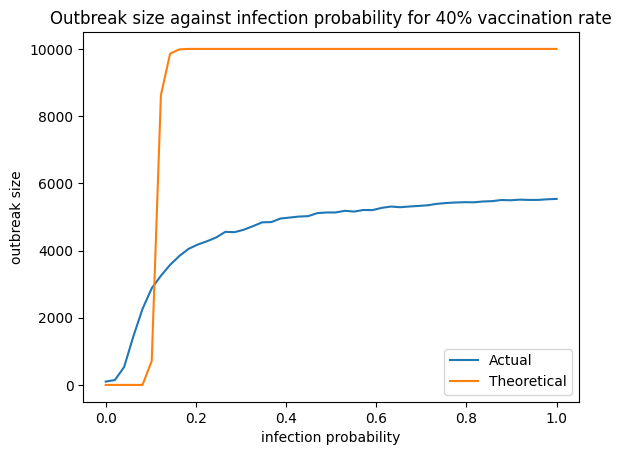

In [99]:
plt.plot(infection_probi_array, geometric_outbreak_array_no_paradox, label="Actual")
plt.plot(infection_probi_array, iterative_case_outbreak_array, label="Theoretical")
plt.legend()
plt.title("Outbreak size against infection probability for 40% vaccination rate")
plt.xlabel("infection probability")
plt.ylabel("outbreak size")
plt.show()